# 차트만

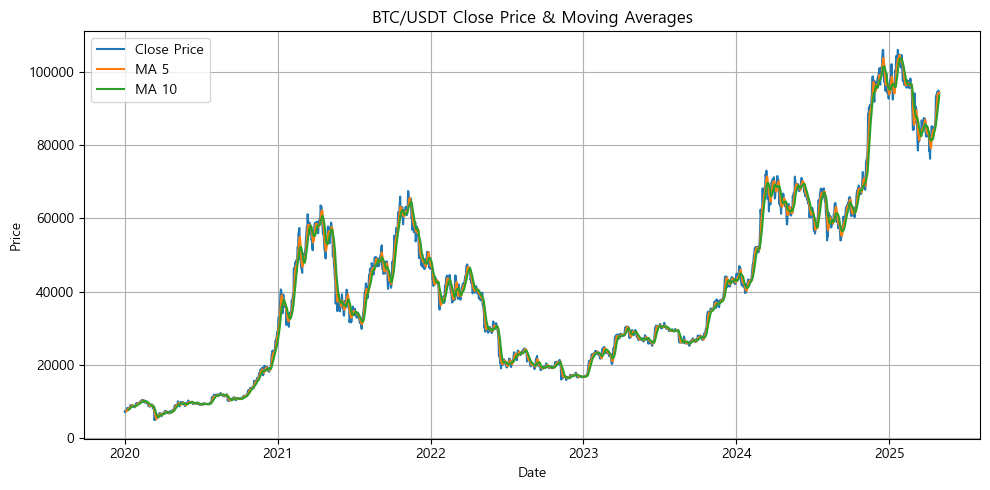

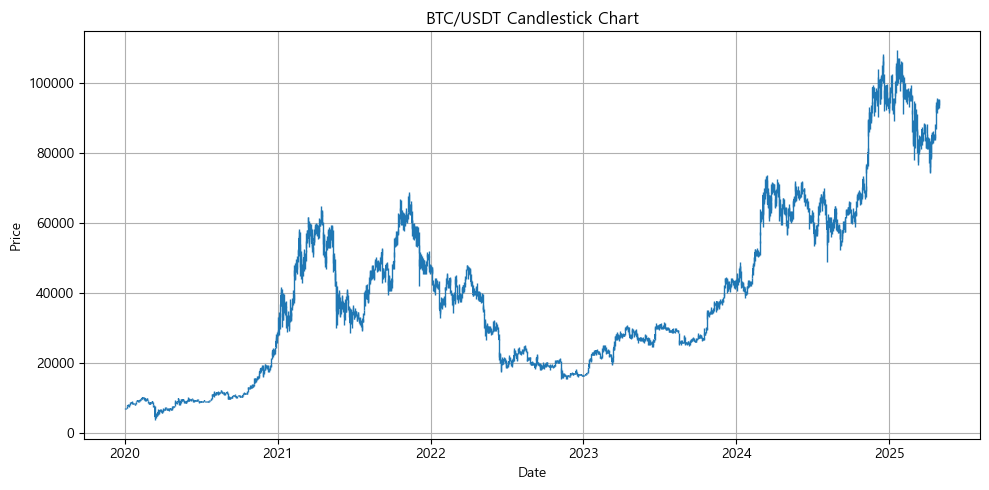

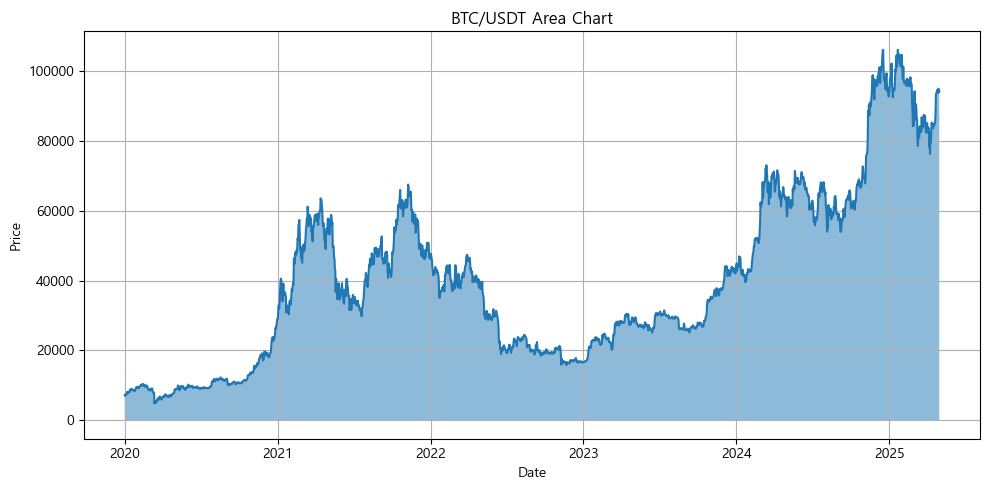

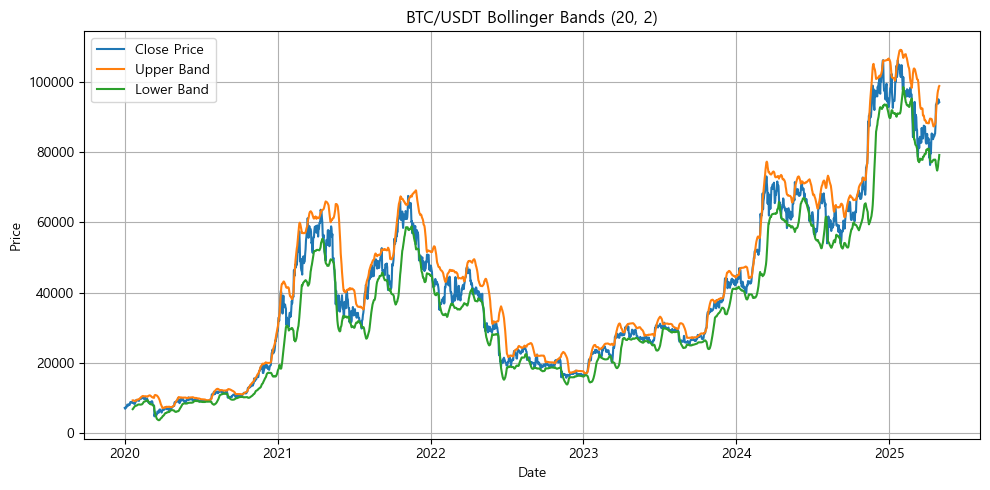

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
df = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Compute Moving Averages
df['MA5'] = df['close'].rolling(5).mean()
df['MA10'] = df['close'].rolling(10).mean()

# Compute Bollinger Bands (20-day)
df['MA20'] = df['close'].rolling(20).mean()
df['STD20'] = df['close'].rolling(20).std()
df['BB_upper'] = df['MA20'] + 2 * df['STD20']
df['BB_lower'] = df['MA20'] - 2 * df['STD20']

# 1) Line chart with Moving Averages
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close'], label='Close Price')
plt.plot(df.index, df['MA5'], label='MA 5')
plt.plot(df.index, df['MA10'], label='MA 10')
plt.title('BTC/USDT Close Price & Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Candlestick chart
df_candle = df[['open', 'high', 'low', 'close']].copy()
df_candle['date_num'] = df_candle.index.map(mdates.date2num)

fig, ax = plt.subplots(figsize=(10, 5))
width = 0.6

for idx, row in df_candle.iterrows():
    # High-low line
    ax.vlines(row['date_num'], row['low'], row['high'], linewidth=1)
    # Rectangle for open-close
    rect_bottom = min(row['open'], row['close'])
    rect_height = abs(row['close'] - row['open'])
    ax.add_patch(plt.Rectangle((row['date_num'] - width / 2, rect_bottom), width, rect_height))
    
ax.xaxis_date()
ax.set_title('BTC/USDT Candlestick Chart')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Area chart for Close Price
plt.figure(figsize=(10, 5))
plt.fill_between(df.index, df['close'], alpha=0.5)
plt.plot(df.index, df['close'], label='Close Price')
plt.title('BTC/USDT Area Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Bollinger Bands chart
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close'], label='Close Price')
plt.plot(df.index, df['BB_upper'], label='Upper Band')
plt.plot(df.index, df['BB_lower'], label='Lower Band')
plt.title('BTC/USDT Bollinger Bands (20, 2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 하이킨 아시 차트

C:\Users\78831\AppData\Local\Temp\ipykernel_36688\1617033432.py:28: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



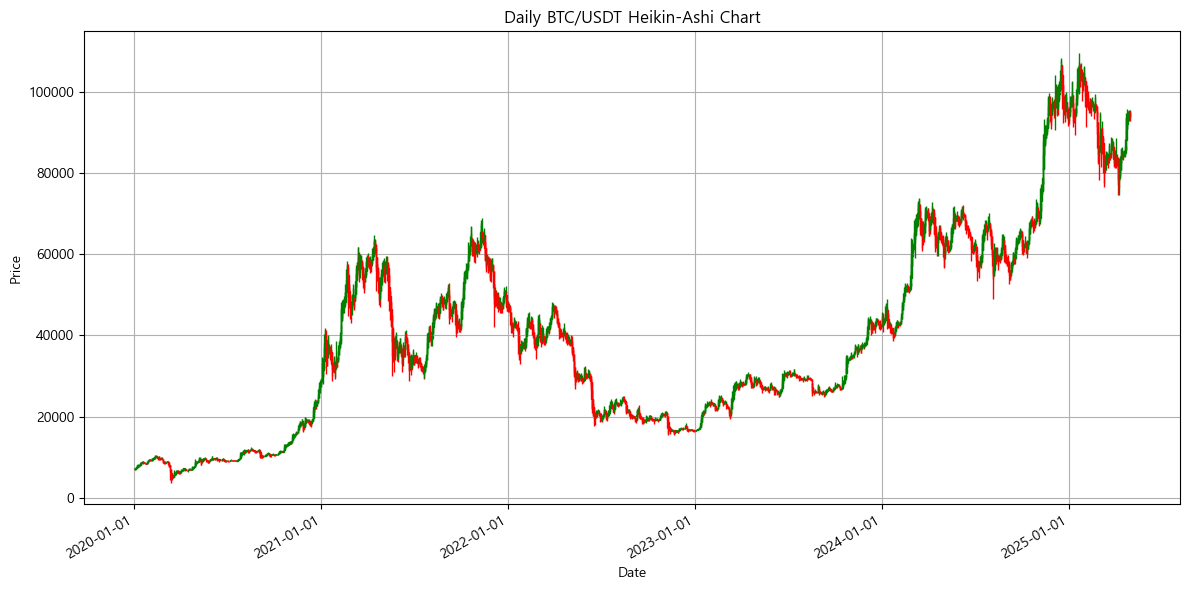

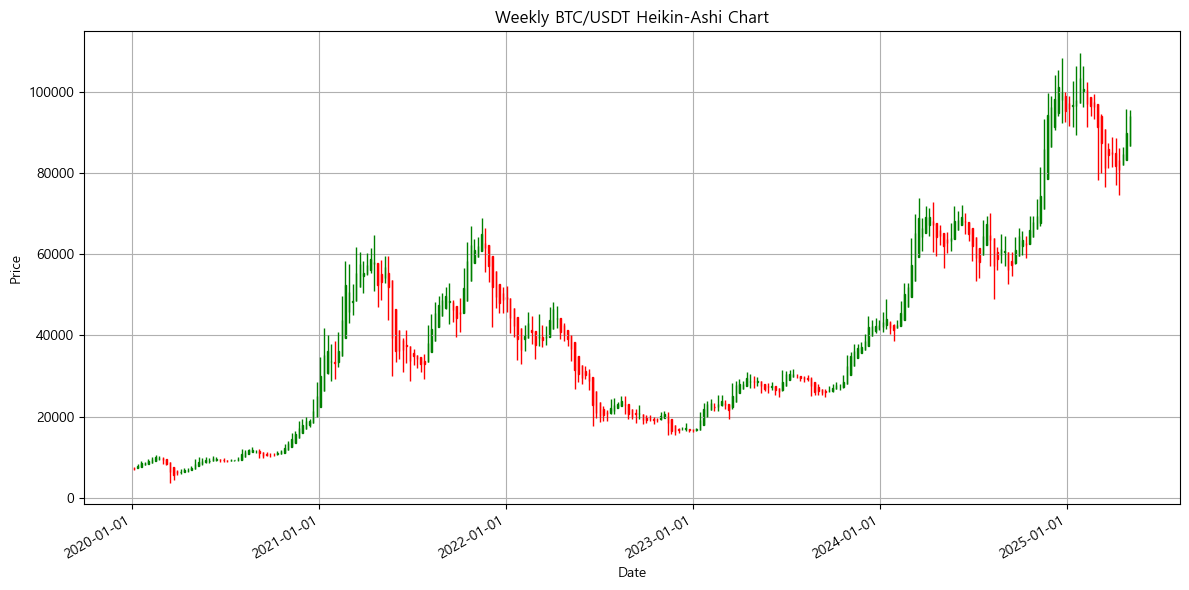

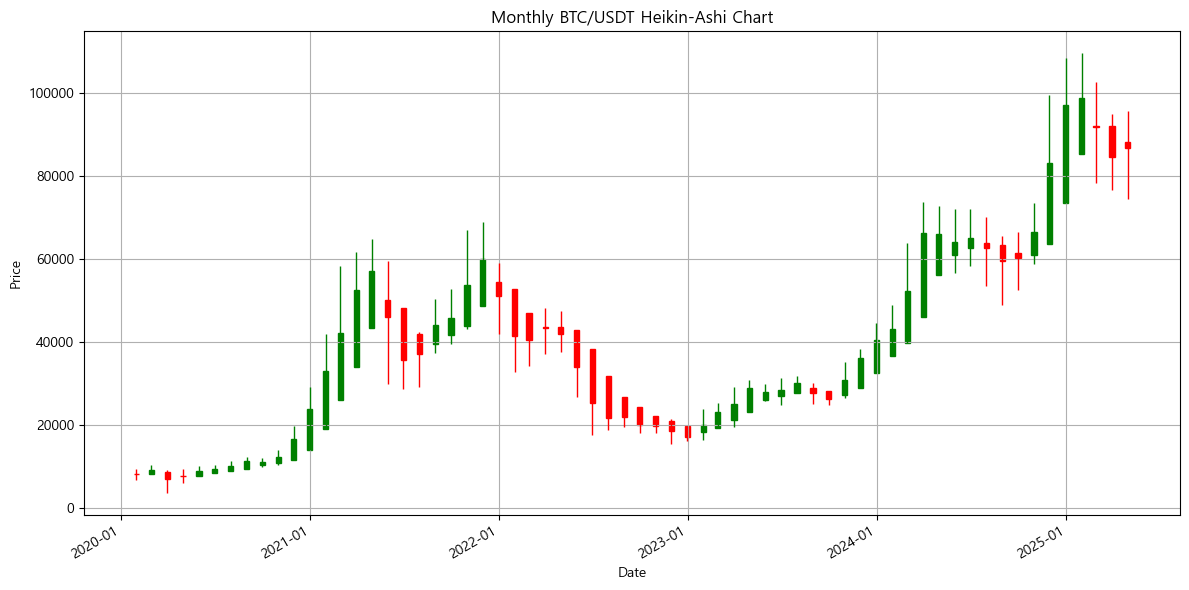

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data (경로를 실제 파일 위치에 맞춰 조정)
df = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

def compute_heikin_ashi(resampled_df):
    ha = pd.DataFrame(index=resampled_df.index, columns=['HA_Open', 'HA_High', 'HA_Low', 'HA_Close'])
    ha['HA_Close'] = (resampled_df['open'] + resampled_df['high'] + resampled_df['low'] + resampled_df['close']) / 4
    ha.iloc[0, ha.columns.get_loc('HA_Open')] = (resampled_df.iloc[0]['open'] + resampled_df.iloc[0]['close']) / 2
    for i in range(1, len(resampled_df)):
        ha.iloc[i, ha.columns.get_loc('HA_Open')] = (ha.iloc[i-1]['HA_Open'] + ha.iloc[i-1]['HA_Close']) / 2
    temp_high = pd.concat([ha['HA_Open'], ha['HA_Close'], resampled_df['high']], axis=1)
    ha['HA_High'] = temp_high.max(axis=1)
    temp_low  = pd.concat([ha['HA_Open'], ha['HA_Close'], resampled_df['low']], axis=1)
    ha['HA_Low']  = temp_low.min(axis=1)
    ha['date_num'] = ha.index.map(mdates.date2num)
    return ha

# Daily Heikin-Ashi
ha_daily = compute_heikin_ashi(df)

# Weekly and Monthly Resample
weekly = df.resample('W').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':'sum'}).dropna()
monthly = df.resample('M').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':'sum'}).dropna()
ha_weekly = compute_heikin_ashi(weekly)
ha_monthly = compute_heikin_ashi(monthly)

# Plot Daily HA
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.6
for _, row in ha_daily.iterrows():
    color = 'green' if row['HA_Close'] >= row['HA_Open'] else 'red'
    ax.vlines(row['date_num'], row['HA_Low'], row['HA_High'], color=color, linewidth=1)
    bottom = min(row['HA_Open'], row['HA_Close'])
    height = abs(row['HA_Close'] - row['HA_Open'])
    ax.add_patch(plt.Rectangle((row['date_num'] - width/2, bottom), width, height, facecolor=color, edgecolor=color))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate()
ax.set_title('Daily BTC/USDT Heikin-Ashi Chart')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.grid(True)
plt.tight_layout()
plt.show()

# Plot Weekly HA
fig, ax = plt.subplots(figsize=(12, 6))
width = 1.0
for _, row in ha_weekly.iterrows():
    color = 'green' if row['HA_Close'] >= row['HA_Open'] else 'red'
    ax.vlines(row['date_num'], row['HA_Low'], row['HA_High'], color=color, linewidth=1)
    bottom = min(row['HA_Open'], row['HA_Close'])
    height = abs(row['HA_Close'] - row['HA_Open'])
    ax.add_patch(plt.Rectangle((row['date_num'] - width/2, bottom), width, height, facecolor=color, edgecolor=color))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate()
ax.set_title('Weekly BTC/USDT Heikin-Ashi Chart')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.grid(True)
plt.tight_layout()
plt.show()

# Plot Monthly HA
fig, ax = plt.subplots(figsize=(12, 6))
width = 10
for _, row in ha_monthly.iterrows():
    color = 'green' if row['HA_Close'] >= row['HA_Open'] else 'red'
    ax.vlines(row['date_num'], row['HA_Low'], row['HA_High'], color=color, linewidth=1)
    bottom = min(row['HA_Open'], row['HA_Close'])
    height = abs(row['HA_Close'] - row['HA_Open'])
    ax.add_patch(plt.Rectangle((row['date_num'] - width/2, bottom), width, height, facecolor=color, edgecolor=color))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate()
ax.set_title('Monthly BTC/USDT Heikin-Ashi Chart')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.grid(True)
plt.tight_layout()
plt.show()


# 온체인만

In [18]:
import pandas as pd

# 1) CSV 불러오기
df_chain = pd.read_csv('./onchain/usdt_onchain_250101_250430.csv')

# 2) 컬럼명 확인 (혹시 공백 또는 다른 이름인지 확인)
# print(df_chain.columns)
# 만약 "ValueUSD" 대신 "ValueUSD " 또는 "Value (USD)" 등의 다른 이름이 보인다면,
# 코드 내에서 해당 이름을 사용해야 합니다.

# 3) 'ValueUSD'를 문자열로 캐스팅한 뒤 달러 기호와 쉼표 제거 → float 변환
df_chain['ValueUSD'] = (
    df_chain['ValueUSD']
    .astype(str)                         # 문자열이 아닌 값이 섞여 있어도 안전하게 처리
    .str.replace(r'[$,]', '', regex=True)
    .str.strip()                         # 끝부분 공백 제거
    .astype(float)
)

# 4) 'Amount'를 숫자형으로 변환
df_chain['Amount'] = pd.to_numeric(df_chain['Amount'], errors='coerce')

# 5) 전체 트랜잭션 건수 및 총 전송 금액(USD) 계산
total_txns = len(df_chain)
total_volume_usd = df_chain['ValueUSD'].sum()

print(f"전체 트랜잭션 건수: {total_txns}")
print(f"총 전송 금액 (USD): {total_volume_usd:,.2f}")

# 6) Asset별 요약 통계 (트랜잭션 건수, USD 합계, Amount 합계)
asset_summary = (
    df_chain
    .groupby('Asset')
    .agg(
        txns_count=('Transaction Hash', 'count'),
        total_usd=('ValueUSD', 'sum'),
        total_amount=('Amount', 'sum')
    )
    .reset_index()
)
print("\n=== Asset별 요약 ===")
print(asset_summary)

# 7) 상위 10개 트랜잭션 (USD 기준)
top10 = df_chain.nlargest(10, 'ValueUSD')[['Transaction Hash', 'From', 'To', 'ValueUSD']]
print("\n=== 상위 10개 트랜잭션 (USD 기준) ===")
print(top10)

# 8) 주요 지갑(From/To)별 누적 전송 USD 합계
from_summary = (
    df_chain
    .groupby('From')
    .agg(
        total_sent_usd=('ValueUSD', 'sum'),
        txns_count=('Transaction Hash', 'count')
    )
    .reset_index()
    .sort_values('total_sent_usd', ascending=False)
    .head(10)
)

to_summary = (
    df_chain
    .groupby('To')
    .agg(
        total_received_usd=('ValueUSD', 'sum'),
        txns_count=('Transaction Hash', 'count')
    )
    .reset_index()
    .sort_values('total_received_usd', ascending=False)
    .head(10)
)

print("\n=== 상위 10개 발신(From) 지갑 ===")
print(from_summary)
print("\n=== 상위 10개 수신(To) 지갑 ===")
print(to_summary)


전체 트랜잭션 건수: 2706
총 전송 금액 (USD): 208,559,682,234.30

=== Asset별 요약 ===
                 Asset  txns_count     total_usd  total_amount
0     $100,000,000.00           42  4.200000e+09           0.0
1     $100,000,000.02            1  1.000000e+08           0.0
2     $100,000,000.10           16  1.600000e+09           0.0
3     $100,000,000.13            1  1.000000e+08           0.0
4     $100,000,091.00            1  1.000001e+08           0.0
...                ...         ...           ...           ...
1449   $99,999,996.00            2  2.000000e+08           0.0
1450   $99,999,997.00            4  4.000000e+08           0.0
1451   $99,999,998.00            6  6.000000e+08           0.0
1452   $99,999,999.00            8  8.000000e+08           0.0
1453   $99,999,999.30            2  2.000000e+08           0.0

[1454 rows x 4 columns]

=== 상위 10개 트랜잭션 (USD 기준) ===
                                       Transaction Hash          From  \
2476  0x346b1ea3907e49e200e4b7008165546c6f710e

Index(['Source.Name', 'Transaction Hash', 'Status', 'Type', 'Method', 'Block',
       'Age', 'From', 'FromNameTag', 'To', 'ToNameTag', 'Amount', 'ValueUSD',
       'Asset', 'Txn Fee', 'Column1', 'Date'],
      dtype='object')


C:\Users\78831\AppData\Local\Temp\ipykernel_36688\309386707.py:28: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\78831\AppData\Local\Temp\ipykernel_36688\309386707.py:28: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\78831\AppData\Local\Temp\ipykernel_36688\309386707.py:28: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\78831\AppData\Local\Temp\ipykernel_36688\309386707.py:28: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\78831\AppData\Local\Temp\ipykernel_36688\309386707.py:28: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\78831\AppData\Local\Temp\ipykernel_36688\309386707.py:28: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font

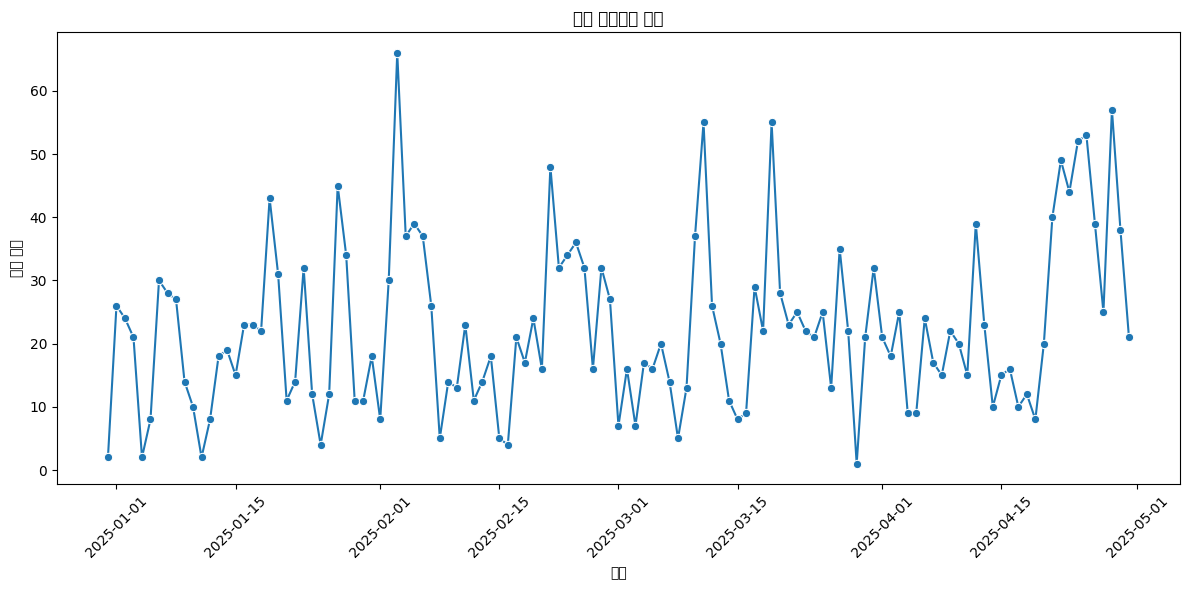

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) CSV 불러오기
df_chain = pd.read_csv('./onchain/usdt_onchain_250101_250430.csv')

# 2) 컬럼명 확인 (Date 또는 Timestamp 컬럼이 있는지 확인)
print(df_chain.columns)

# 3) 'Date' 컬럼이 있다고 가정하고 datetime으로 변환
#    만약 실제 컬럼명이 다르다면, 아래 'Date' 대신 해당 컬럼명으로 바꿔주세요.
df_chain['Date'] = pd.to_datetime(df_chain['Date'])

# 4) 'date_only' 컬럼 생성 (연-월-일 단위로)
df_chain['date_only'] = df_chain['Date'].dt.date

# 5) 일별 트랜잭션 개수 집계
daily_count = df_chain.groupby('date_only').size().reset_index(name='count')

# 6) Seaborn으로 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_count, x='date_only', y='count', marker='o')
plt.xticks(rotation=45)
plt.title('일별 트랜잭션 건수')
plt.xlabel('날짜')
plt.ylabel('거래 건수')
plt.tight_layout()
plt.show()


# 시간 형식 변환하고 행에 추가하기

In [3]:
import pandas as pd
from datetime import datetime, timedelta

# 1) CSV 파일 로드
file_path = './onchain/usdt_onchain.csv'
df = pd.read_csv(file_path)

# 2) 컬럼명 앞뒤 공백 제거 (필요 시)
df.columns = df.columns.str.strip()

# 3) 기준 날짜(2025-04-30) 설정
reference_date = datetime(2025, 5, 31)

# 4) 'Age' 컬럼에 있는 문자열(예: "30 days ago")을 실제 datetime으로 변환하는 함수 정의
def age_to_datetime(age_str):
    try:
        parts = age_str.split()
        number = int(parts[0])
        unit = parts[1]
        if 'day' in unit:
            return reference_date - timedelta(days=number)
        elif 'hour' in unit:
            return reference_date - timedelta(hours=number)
        elif 'minute' in unit:
            return reference_date - timedelta(minutes=number)
        else:
            return pd.NaT
    except:
        return pd.NaT

# 5) 변환 적용 및 새로운 'Date' 컬럼 생성 (Age 컬럼 사용)
df['Date'] = df['From'].apply(age_to_datetime)

# 6) 'Date' 컬럼을 이용해 Unix 타임스탬프(초 단위) 추가
df['Timestamp'] = df['Date'].apply(lambda x: int(x.timestamp()) if pd.notna(x) else None)

# 7) 결과 확인 (상위 몇 개 행 출력)
print(df[['Age', 'Date', 'Timestamp']].head())

# 8) 기존 파일 덮어쓰기
df.to_csv(file_path, index=False, encoding='utf-8-sig')

print("CSV 파일에 'Date' 컬럼과 'Timestamp' 컬럼이 추가되고 덮어쓰기가 완료되었습니다.")


        Age       Date   Timestamp
0  22385286 2025-04-30  1745971200
1  22385285 2025-04-30  1745971200
2  22385265 2025-04-30  1745971200
3  22384537 2025-04-30  1745971200
4  22384432 2025-04-30  1745971200
CSV 파일에 'Date' 컬럼과 'Timestamp' 컬럼이 추가되고 덮어쓰기가 완료되었습니다.


### 차트 + 온체인 혼합

종가와 일별 온체인 USD 합계 간 상관계수: -0.0651


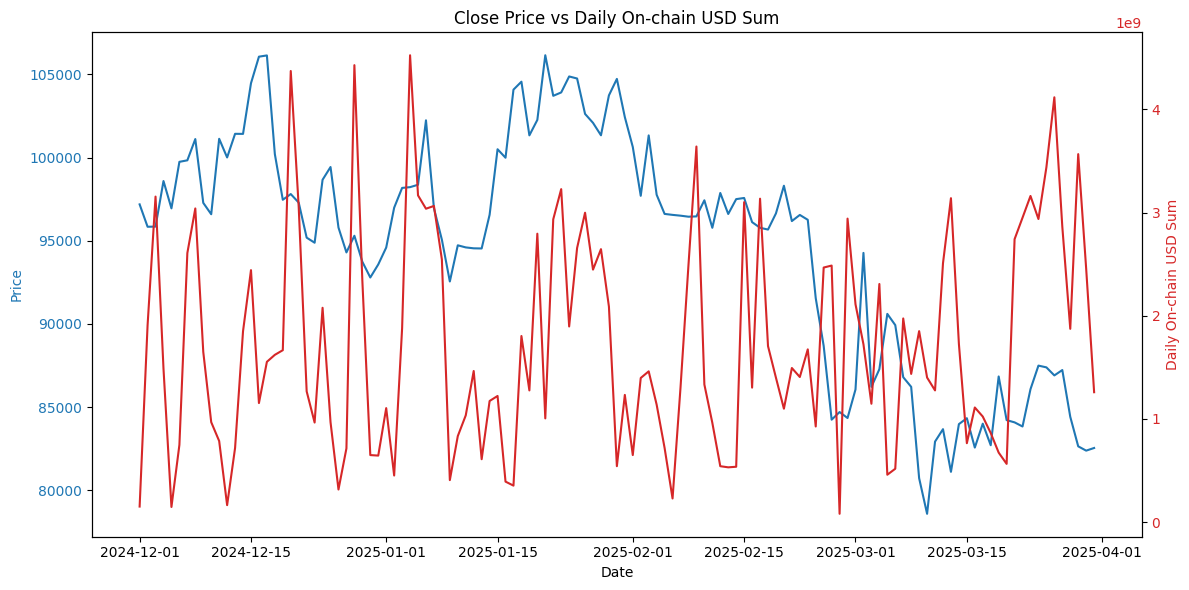

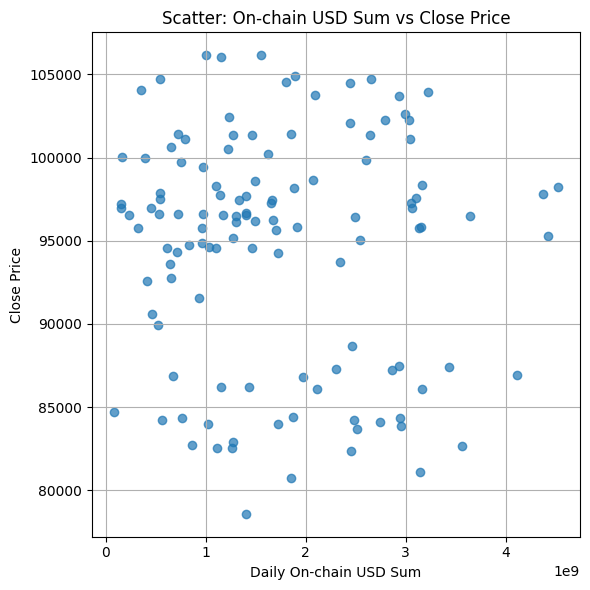

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 차트 데이터 불러오기
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.set_index('date', inplace=True)
df_chart.sort_index(inplace=True)

# 2) 온체인 데이터 불러오기 (여기서는 이미 'Date' 컬럼이 있는 것으로 가정)
df_chain = pd.read_csv('./onchain/usdt_onchain_250101_250430.csv', parse_dates=['Date'])

# 3) 온체인 데이터를 일별 합계(USD 기준)로 집계
# df_chain['ValueUSD'] = df_chain['ValueUSD'].str.replace(r'[$,]', '', regex=True).astype(float)
daily_chain = df_chain.groupby(df_chain['Date'].dt.floor('D')).agg(
    daily_txns_count=('Transaction Hash', 'count'),
    daily_total_usd=('ValueUSD', 'sum')
).rename_axis('date').reset_index()

# 4) 차트 데이터와 온체인 집계 데이터 병합
#    df_chart에는 index로 date가 있고, daily_chain은 컬럼 'date'를 가진 상태
merged = df_chart.reset_index().merge(daily_chain, on='date', how='inner')
merged.set_index('date', inplace=True)

# 5) 상관관계 계산
corr_price_volume = merged['close'].corr(merged['daily_total_usd'])
print(f"종가와 일별 온체인 USD 합계 간 상관계수: {corr_price_volume:.4f}")

# 6) 시각화: 한 플롯에 Price와 온체인 USD 합계 (스케일 차이가 크므로 보조축 사용)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(merged.index, merged['close'], color='tab:blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(merged.index, merged['daily_total_usd'], color='tab:red', label='On-chain USD Sum')
ax2.set_ylabel('Daily On-chain USD Sum', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Close Price vs Daily On-chain USD Sum')
fig.tight_layout()
plt.show()

# 7) 산점도(Scatter)으로도 확인
plt.figure(figsize=(6, 6))
plt.scatter(merged['daily_total_usd'], merged['close'], alpha=0.7)
plt.title('Scatter: On-chain USD Sum vs Close Price')
plt.xlabel('Daily On-chain USD Sum')
plt.ylabel('Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()


### 온체인만2

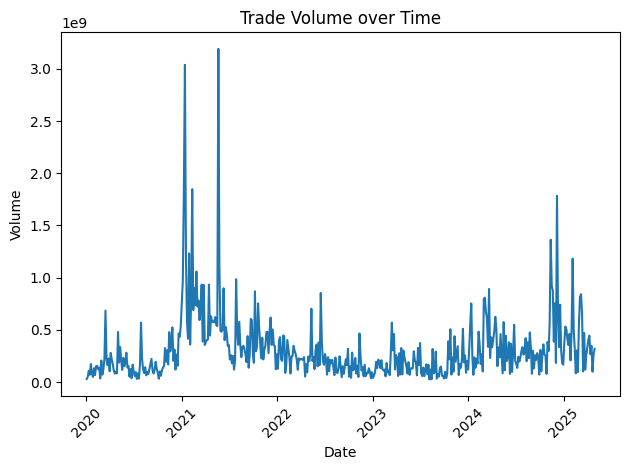

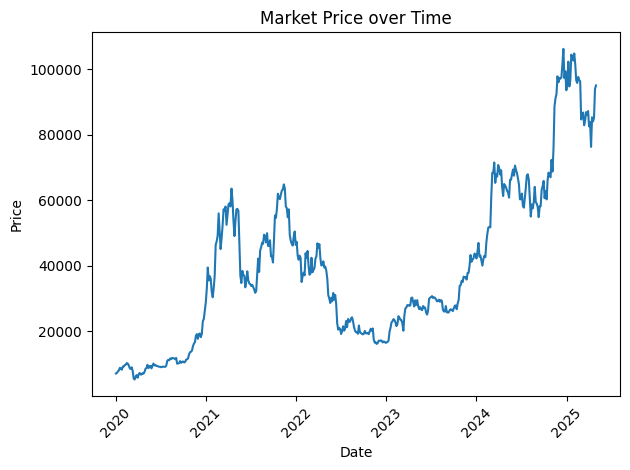

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1. JSON 파일 로드
# =========================
file_path = './onchain/trade-volume.json'
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# =========================
# 2. 'trade-volume' DataFrame 생성
# =========================
df_tv = pd.DataFrame(data['trade-volume'])
df_tv['datetime'] = pd.to_datetime(df_tv['x'], unit='ms')

# =========================
# 3. 'trade-volume' 시각화
# =========================
plt.figure()
plt.plot(df_tv['datetime'], df_tv['y'])
plt.title('Trade Volume over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# 4. 'market-price' DataFrame 생성 (있다면)
# =========================
if 'market-price' in data:
    df_mp = pd.DataFrame(data['market-price'])
    df_mp['datetime'] = pd.to_datetime(df_mp['x'], unit='ms')

    # =========================
    # 5. 'market-price' 시각화
    # =========================
    plt.figure()
    plt.plot(df_mp['datetime'], df_mp['y'])
    plt.title('Market Price over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# pip install plotly

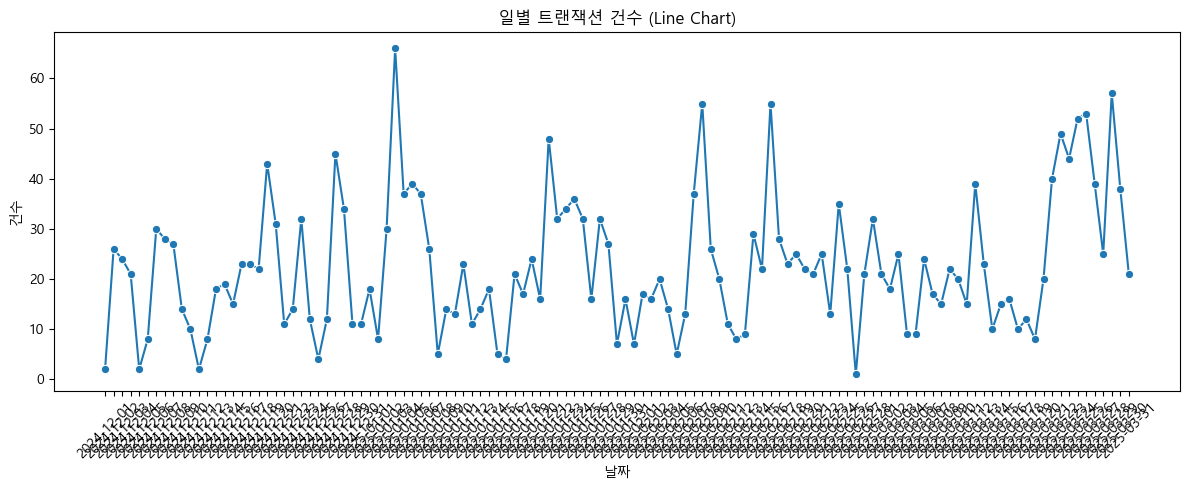

C:\Users\78831\AppData\Local\Temp\ipykernel_36688\3733119111.py:52: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




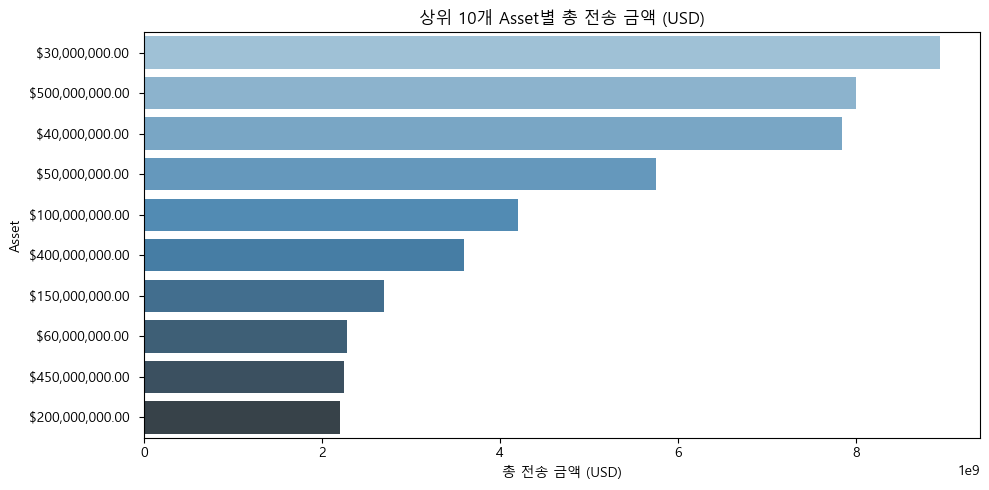

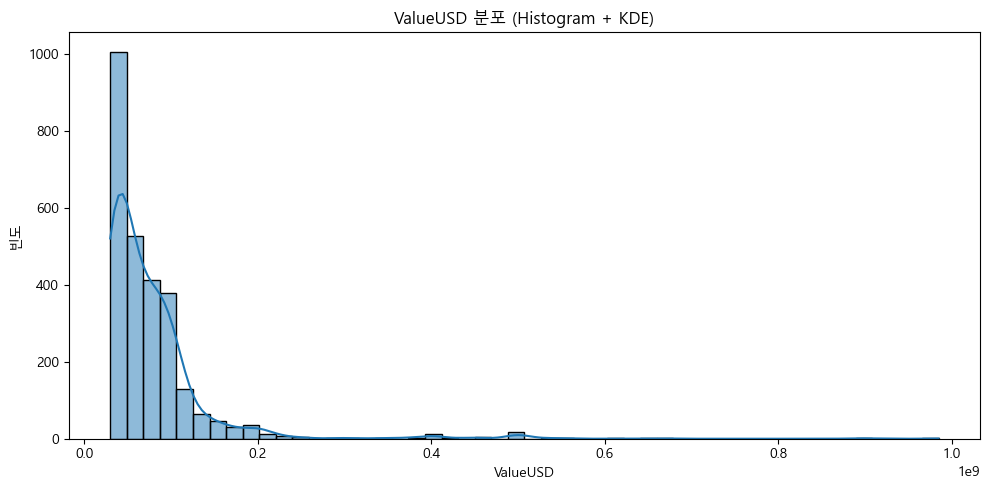

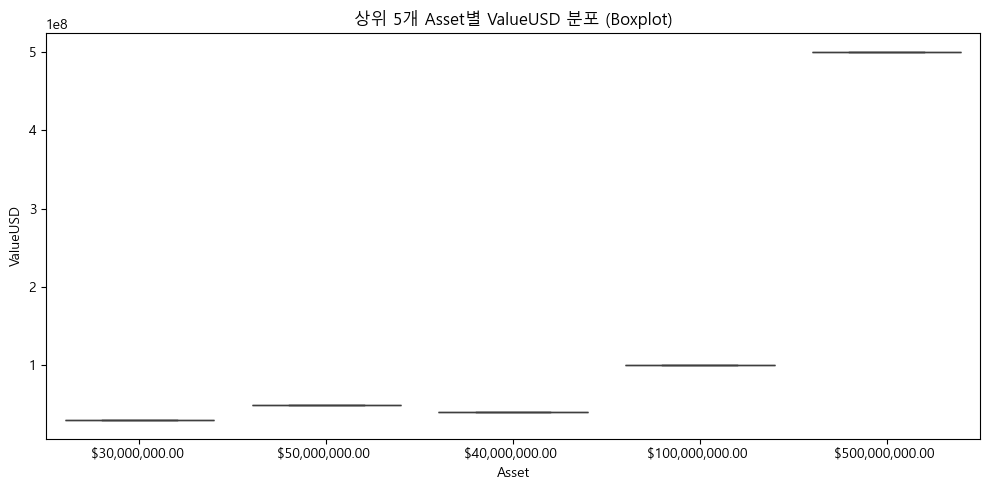

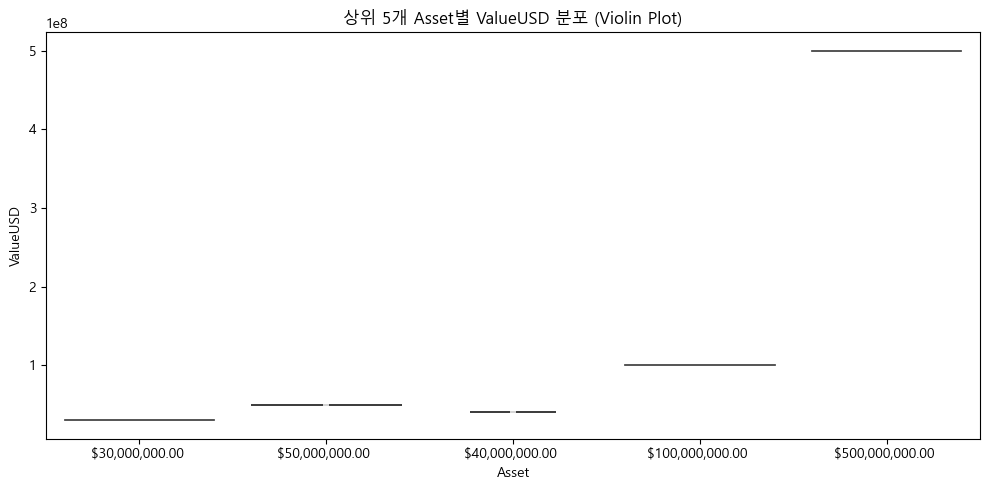

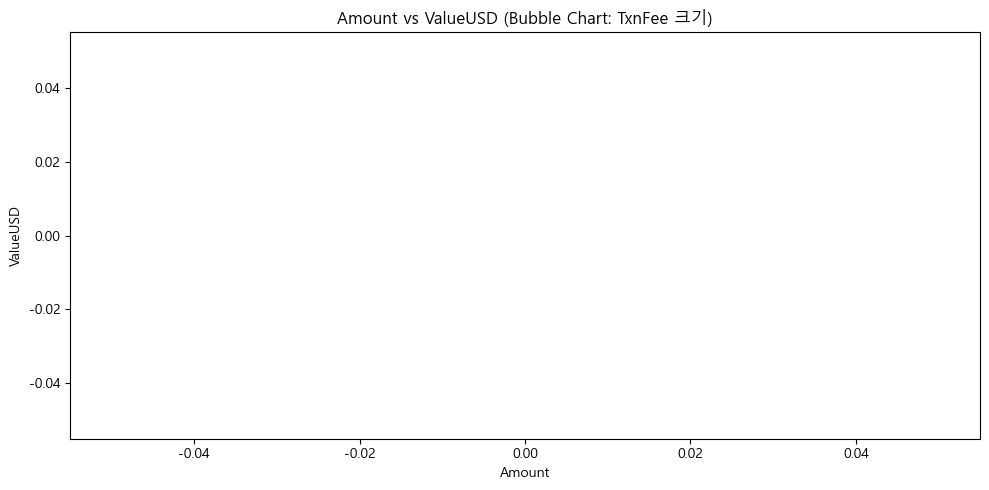

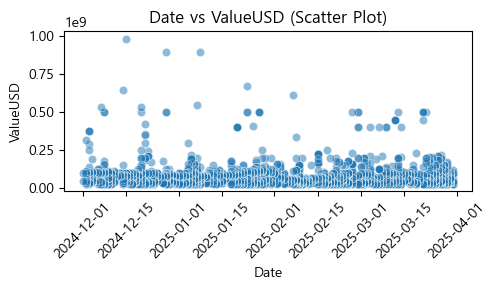

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# 1) 한글 폰트 설정 (환경에 맞게 글꼴명 또는 경로를 수정)
# 윈도우라면 보통 "Malgun Gothic"을 쓸 수 있습니다.
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

# ========================================
# 1. 데이터 로드 및 전처리
# ========================================
file_path = './onchain/usdt_onchain_250101_250430.csv'
df = pd.read_csv(file_path)

# 컬럼명 정리
df.columns = df.columns.str.strip()

# 'Timestamp' 컬럼을 datetime으로 변환해 'Date' 컬럼 생성
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')

# ValueUSD와 Amount 변환
df['ValueUSD'] = df['ValueUSD'].astype(str).str.replace(r'[$,]', '', regex=True).str.strip().astype(float)
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

# 1) Date 컬럼을 datetime으로 변환 (이미 변환된 상태라면 생략 가능)
df['Date'] = pd.to_datetime(df['Date'])

# 2) 원하는 포맷(YYYY-MM-DD)으로 문자열만 추출해서 date_only 컬럼에 저장
df['date_only'] = df['Date'].dt.strftime('%Y-%m-%d')

# ========================================
# 2. Line Chart: 일별 트랜잭션 건수
# ========================================
daily_count = df.groupby('date_only').size().reset_index(name='count')
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_count, x='date_only', y='count', marker='o')
plt.xticks(rotation=45)
plt.title('일별 트랜잭션 건수 (Line Chart)')
plt.xlabel('날짜')
plt.ylabel('건수')
plt.tight_layout()
plt.show()

# ========================================
# 3. Bar Chart: 자산별 총 전송 USD 합계 상위 10
# ========================================
asset_summary = df.groupby('Asset').agg(total_usd=('ValueUSD', 'sum')).reset_index()
top_assets = asset_summary.nlargest(10, 'total_usd')
plt.figure(figsize=(10, 5))
sns.barplot(data=top_assets, x='total_usd', y='Asset', palette='Blues_d')
plt.title('상위 10개 Asset별 총 전송 금액 (USD)')
plt.xlabel('총 전송 금액 (USD)')
plt.ylabel('Asset')
plt.tight_layout()
plt.show()

# ========================================
# 4. Histogram + KDE: ValueUSD 분포
# ========================================
plt.figure(figsize=(10, 5))
sns.histplot(df['ValueUSD'], bins=50, kde=True)
plt.title('ValueUSD 분포 (Histogram + KDE)')
plt.xlabel('ValueUSD')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

# ========================================
# 5. Box/Violin Plot: Asset별 ValueUSD 분포
# ========================================
# 상위 5개 자산만 예시
top5_assets = asset_summary.nlargest(5, 'total_usd')['Asset']
df_top5 = df[df['Asset'].isin(top5_assets)]

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_top5, x='Asset', y='ValueUSD')
plt.title('상위 5개 Asset별 ValueUSD 분포 (Boxplot)')
plt.xlabel('Asset')
plt.ylabel('ValueUSD')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.violinplot(data=df_top5, x='Asset', y='ValueUSD')
plt.title('상위 5개 Asset별 ValueUSD 분포 (Violin Plot)')
plt.xlabel('Asset')
plt.ylabel('ValueUSD')
plt.tight_layout()
plt.show()

# ========================================
# 6. Scatter / Bubble Chart: Amount vs ValueUSD
# ========================================
# 버블 크기는 Txn Fee(숫자로 변환 필요)
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df,
    x='Amount',
    y='ValueUSD',
    size='TxnFee',
    sizes=(20, 200),
    alpha=0.6,
    legend=False
)
plt.title('Amount vs ValueUSD (Bubble Chart: TxnFee 크기)')
plt.xlabel('Amount')
plt.ylabel('ValueUSD')
plt.tight_layout()
plt.show()

# ========================================
# 7. Treemap: Asset별 총 전송 USD 비율
# ========================================
# Plotly Express의 treemap 사용
fig_treemap = px.treemap(
    asset_summary,
    path=['Asset'],
    values='total_usd',
    title='Asset별 총 전송 USD 비율 (Treemap)'
)
fig_treemap.write_html('treemap.html')

# ========================================
# 8. Sunburst: Asset > Type별 트랜잭션 합계 (ValueUSD)
# ========================================
if 'Type' in df.columns:
    sunburst_data = df.groupby(['Asset', 'Type']).agg(total_usd=('ValueUSD', 'sum')).reset_index()
    fig_sunburst = px.sunburst(
        sunburst_data,
        path=['Asset', 'Type'],
        values='total_usd',
        title='Asset별 Type 차원 트랜잭션 합계 (Sunburst)'
    )
    fig_sunburst.write_html('sunburst.html')

# ========================================
# 9. 기본 Scatter Plot: Date vs ValueUSD
# ========================================
plt.figure(figsize=(5, 3))
sns.scatterplot(data=df, x='Date', y='ValueUSD', alpha=0.5)
plt.title('Date vs ValueUSD (Scatter Plot)')
plt.xlabel('Date')
plt.ylabel('ValueUSD')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
